# Survival analysis

Make a dictionary where we have a table for each cancer type that's ready to plug into the plotter. Format: One column of days until last contact or death (duration col), on column of vital status (event col), and a column of true/false for each event (attribute).

Then plot for each cancer type.

In [1]:
import pandas as pd
import numpy as np
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import os

## Prepare tables

In [2]:
cancer_types = [
    "brca",
    "coad",
    "hnsc",
    "luad",
    "lusc",
    "ov"
]

In [3]:
def prepare_plot_table(cancer_type):
    
    # Get the followup data
    fp = pd.read_csv(
        os.path.join("..", "data", cancer_type, f"{str.upper(cancer_type)}_survival.txt.gz"), 
        sep="\t"
    ).\
    rename(columns={"xena_sample": "sample"}).\
    set_index("sample")
    
    vital_status_col = "OS" # Overall survival
    time_col = "OS.time"
    
    # Rename columns for consistency
    fp = fp[[vital_status_col, time_col]].\
    rename(columns={
        vital_status_col: "death",
        time_col: "days_to_last_contact_or_death"
    })
    
    # Combine completely duplicated rows
    fp = fp.reset_index(drop=False) # So that the index is counted in identifying duplicates
    fp = fp[~fp.duplicated(keep="first")]
    fp = fp.set_index("sample")
    
    # That should have taken care of all duplicates. Yay curated data!
    assert fp.index.duplicated().sum() == 0
    
    # Drop any rows with NaNs
    fp = fp.dropna(axis="index", how="any")
    
    # Fill vals
#     fp["death"] = fp["death"].replace({"Deceased": True, "Living": False})
    
    # Load the CNV event table
    event = pd.read_csv(f"{cancer_type}_has_event.tsv", sep="\t", index_col=0).\
    rename(columns={
        "gain_event": "8q_gain",
        "loss_event": "8p_loss"
    })
    
    event = event.assign(
        both=event["8p_loss"] & event["8q_gain"],
        neither=~(event["8p_loss"] | event["8q_gain"])
    )
    
    # Join the two
    joined = fp.join(event, how="inner")
    
    # Check
    assert joined.index.duplicated().sum() == 0
    
    return joined

### Data example

The cell below shows the format we need our data in for the survival analysis. You need three columns:
- Event column (whether they have passed away): Boolean
- Duration column (days until death or last contact): Numeric
- Covariate column (whether each patient had the event): Boolean

In [4]:
prepare_plot_table("brca").head()

,death,days_to_last_contact_or_death,8q_gain,8p_loss,both,neither
TCGA-3C-AAAU-01,0,4047.0,True,False,False,False
TCGA-3C-AALI-01,0,4005.0,True,False,False,False
TCGA-3C-AALJ-01,0,1474.0,True,True,True,False
TCGA-3C-AALK-01,0,1448.0,False,False,False,True
TCGA-4H-AAAK-01,0,348.0,False,True,False,False


## Plot individual variables

In [5]:
def plot_single_var_survival(cancer_type, df, cnv_col):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(f"{cancer_type} - {cnv_col}")
    cph.print_summary()
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_event_count = df[cnv_col].sum()
    no_event_count = df[cnv_col].size - has_event_count
    
    plot_title = f"{cancer_type} survival: {cnv_col}\n{deceased_count} deceased, {living_count} living\n {has_event_count} with event, {no_event_count} without event"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_col, 
        values=[False, True],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

brca - 8p_loss


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -830.60
         time fit was run = 2020-11-06 01:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.50       1.65       0.17             0.17             0.83                 1.18                 2.30

             z      p   -log2(p)
covariate                       
8p_loss   2.93 <0.005       8.22
---
Concordance = 0.56
Partial AIC = 1663.19
log-likelihood ratio test = 8.88 on 1 df
-log2(p) of ll-ratio test = 8.44

brca - 8q_gain


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -834.32
         time fit was run = 2020-11-06 01:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.20       1.22       0.16            -0.12             0.52                 0.88                 1.68

             z    p   -log2(p)
covariate                     
8q_gain   1.20 0.23       2.13
---
Concordance = 0.54
Partial AIC = 1670.64
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.11

brca - both


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -833.07
         time fit was run = 2020-11-06 01:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both        0.34       1.40       0.17             0.01             0.67                 1.01                 1.95

             z    p   -log2(p)
covariate                     
both      2.02 0.04       4.54
---
Concordance = 0.54
Partial AIC = 1668.13
log-likelihood ratio test = 3.94 on 1 df
-log2(p) of ll-ratio test = 4.41

brca - neither


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -831.87
         time fit was run = 2020-11-06 01:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.48       0.62       0.20            -0.86            -0.09                 0.42                 0.91

              z    p   -log2(p)
covariate                      
neither   -2.42 0.02       6.00
---
Concordance = 0.55
Partial AIC = 1665.75
log-likelihood ratio test = 6.32 on 1 df
-log2(p) of ll-ratio test = 6.39

coad - 8p_loss


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -535.91
         time fit was run = 2020-11-06 01:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.22       1.25       0.20            -0.17             0.61                 0.84                 1.84

             z    p   -log2(p)
covariate                     
8p_loss   1.11 0.27       1.90
---
Concordance = 0.52
Partial AIC = 1073.82
log-likelihood ratio test = 1.21 on 1 df
-log2(p) of ll-ratio test = 1.88

coad - 8q_gain


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -536.36
         time fit was run = 2020-11-06 01:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.11       1.12       0.20            -0.28             0.50                 0.76                 1.65

             z    p   -log2(p)
covariate                     
8q_gain   0.55 0.58       0.78
---
Concordance = 0.51
Partial AIC = 1074.73
log-likelihood ratio test = 0.30 on 1 df
-log2(p) of ll-ratio test = 0.78

coad - both


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -536.27
         time fit was run = 2020-11-06 01:21:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both        0.15       1.16       0.21            -0.27             0.57                 0.77                 1.76

             z    p   -log2(p)
covariate                     
both      0.70 0.48       1.06
---
Concordance = 0.51
Partial AIC = 1074.55
log-likelihood ratio test = 0.49 on 1 df
-log2(p) of ll-ratio test = 1.04

coad - neither


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -535.98
         time fit was run = 2020-11-06 01:21:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.22       0.81       0.21            -0.63             0.20                 0.53                 1.22

              z    p   -log2(p)
covariate                      
neither   -1.03 0.30       1.72
---
Concordance = 0.52
Partial AIC = 1073.96
log-likelihood ratio test = 1.07 on 1 df
-log2(p) of ll-ratio test = 1.73

hnsc - 8p_loss


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1201.58
         time fit was run = 2020-11-06 01:21:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.32       1.38       0.14             0.05             0.59                 1.06                 1.80

             z    p   -log2(p)
covariate                     
8p_loss   2.36 0.02       5.77
---
Concordance = 0.54
Partial AIC = 2405.17
log-likelihood ratio test = 5.57 on 1 df
-log2(p) of ll-ratio test = 5.77

hnsc - 8q_gain


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1204.00
         time fit was run = 2020-11-06 01:21:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.12       1.13       0.14            -0.15             0.39                 0.86                 1.48

             z    p   -log2(p)
covariate                     
8q_gain   0.87 0.38       1.39
---
Concordance = 0.52
Partial AIC = 2409.99
log-likelihood ratio test = 0.74 on 1 df
-log2(p) of ll-ratio test = 1.36

hnsc - both


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1203.57
         time fit was run = 2020-11-06 01:21:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both        0.18       1.19       0.14            -0.10             0.45                 0.91                 1.57

             z    p   -log2(p)
covariate                     
both      1.26 0.21       2.27
---
Concordance = 0.53
Partial AIC = 2409.13
log-likelihood ratio test = 1.60 on 1 df
-log2(p) of ll-ratio test = 2.28

hnsc - neither


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1201.80
         time fit was run = 2020-11-06 01:21:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.37       0.69       0.16            -0.69            -0.05                 0.50                 0.95

              z    p   -log2(p)
covariate                      
neither   -2.24 0.02       5.33
---
Concordance = 0.54
Partial AIC = 2405.59
log-likelihood ratio test = 5.14 on 1 df
-log2(p) of ll-ratio test = 5.42

luad - 8p_loss


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.86
         time fit was run = 2020-11-06 01:21:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.04       1.04       0.15            -0.25             0.33                 0.78                 1.40

             z    p   -log2(p)
covariate                     
8p_loss   0.29 0.77       0.37
---
Concordance = 0.50
Partial AIC = 1935.72
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.37

luad - 8q_gain


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.31
         time fit was run = 2020-11-06 01:21:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.16       1.17       0.15            -0.13             0.45                 0.88                 1.57

             z    p   -log2(p)
covariate                     
8q_gain   1.09 0.28       1.86
---
Concordance = 0.53
Partial AIC = 1934.63
log-likelihood ratio test = 1.17 on 1 df
-log2(p) of ll-ratio test = 1.84

luad - both


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.90
         time fit was run = 2020-11-06 01:21:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both       -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.37

              z    p   -log2(p)
covariate                      
both      -0.06 0.95       0.07
---
Concordance = 0.50
Partial AIC = 1935.79
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.07

luad - neither


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -965.74
         time fit was run = 2020-11-06 01:21:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.25       0.78       0.16            -0.57             0.08                 0.57                 1.08

              z    p   -log2(p)
covariate                      
neither   -1.50 0.13       2.90
---
Concordance = 0.53
Partial AIC = 1933.49
log-likelihood ratio test = 2.31 on 1 df
-log2(p) of ll-ratio test = 2.96

lusc - 8p_loss


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1137.26
         time fit was run = 2020-11-06 01:21:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.10       1.11       0.14            -0.18             0.38                 0.84                 1.47

             z    p   -log2(p)
covariate                     
8p_loss   0.72 0.47       1.09
---
Concordance = 0.51
Partial AIC = 2276.53
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.09

lusc - 8q_gain


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1137.17
         time fit was run = 2020-11-06 01:21:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.12       1.12       0.14            -0.15             0.38                 0.86                 1.47

             z    p   -log2(p)
covariate                     
8q_gain   0.85 0.40       1.34
---
Concordance = 0.53
Partial AIC = 2276.33
log-likelihood ratio test = 0.72 on 1 df
-log2(p) of ll-ratio test = 1.33

lusc - both


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1137.46
         time fit was run = 2020-11-06 01:21:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both        0.05       1.05       0.15            -0.24             0.34                 0.79                 1.40

             z    p   -log2(p)
covariate                     
both      0.35 0.73       0.46
---
Concordance = 0.51
Partial AIC = 2276.93
log-likelihood ratio test = 0.12 on 1 df
-log2(p) of ll-ratio test = 0.46

lusc - neither


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1136.37
         time fit was run = 2020-11-06 01:21:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.27       0.77       0.18            -0.61             0.08                 0.54                 1.08

              z    p   -log2(p)
covariate                      
neither   -1.52 0.13       2.95
---
Concordance = 0.52
Partial AIC = 2274.74
log-likelihood ratio test = 2.31 on 1 df
-log2(p) of ll-ratio test = 2.96

ov - 8p_loss


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1808.88
         time fit was run = 2020-11-06 01:21:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.07       1.08       0.11            -0.14             0.29                 0.87                 1.33

             z    p   -log2(p)
covariate                     
8p_loss   0.66 0.51       0.98
---
Concordance = 0.52
Partial AIC = 3619.77
log-likelihood ratio test = 0.43 on 1 df
-log2(p) of ll-ratio test = 0.96

ov - 8q_gain


/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:624: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1806.42
         time fit was run = 2020-11-06 01:21:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.25       1.29       0.11             0.04             0.47                 1.04                 1.60

             z    p   -log2(p)
covariate                     
8q_gain   2.31 0.02       5.58
---
Concordance = 0.54
Partial AIC = 3614.83
log-likelihood ratio test = 5.36 on 1 df
-log2(p) of ll-ratio test = 5.60

ov - both


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1808.58
         time fit was run = 2020-11-06 01:21:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both        0.12       1.13       0.13            -0.12             0.37                 0.88                 1.45

             z    p   -log2(p)
covariate                     
both      0.98 0.33       1.61
---
Concordance = 0.53
Partial AIC = 3619.16
log-likelihood ratio test = 1.03 on 1 df
-log2(p) of ll-ratio test = 1.69

ov - neither


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1806.42
         time fit was run = 2020-11-06 01:21:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.30       0.74       0.12            -0.54            -0.05                 0.58                 0.95

              z    p   -log2(p)
covariate                      
neither   -2.37 0.02       5.82
---
Concordance = 0.54
Partial AIC = 3614.83
log-likelihood ratio test = 5.37 on 1 df
-log2(p) of ll-ratio test = 5.61

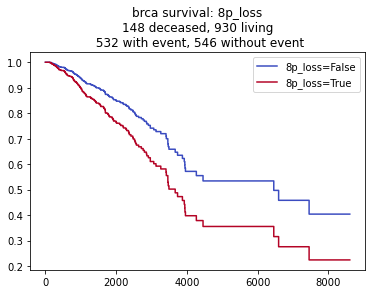

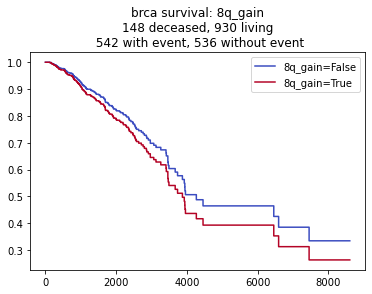

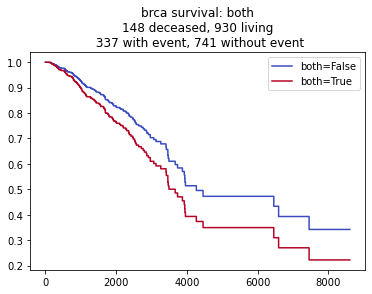

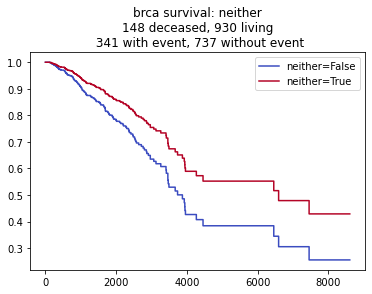

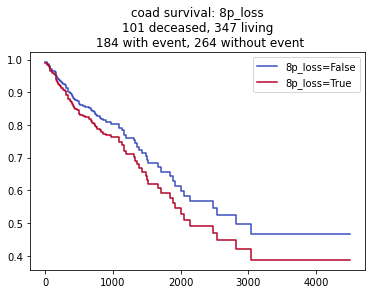

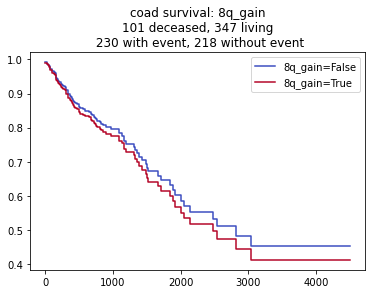

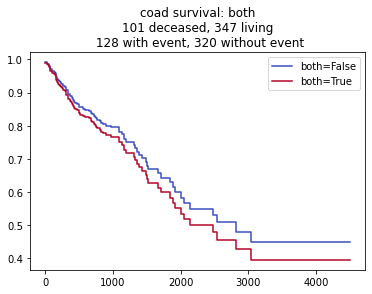

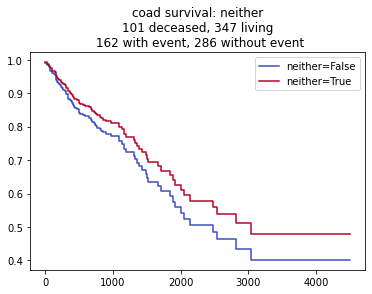

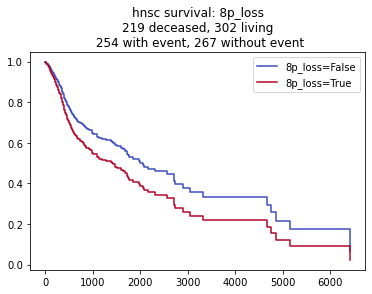

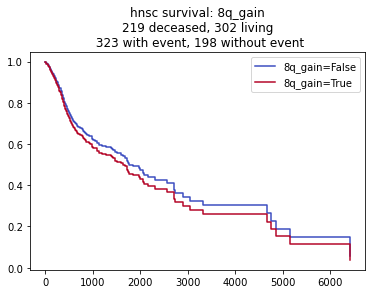

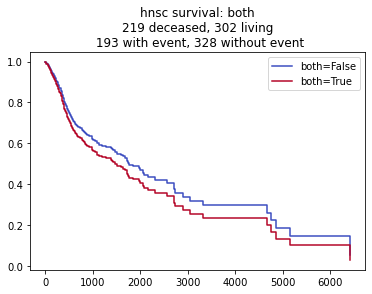

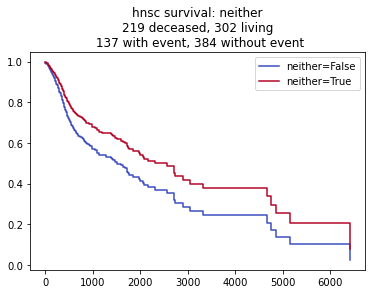

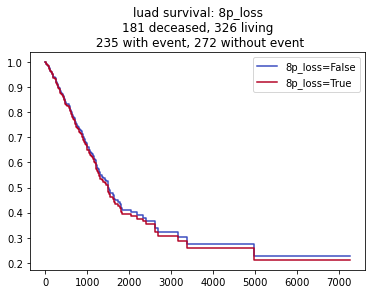

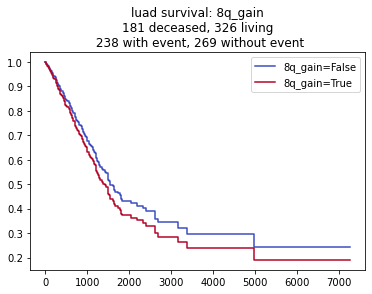

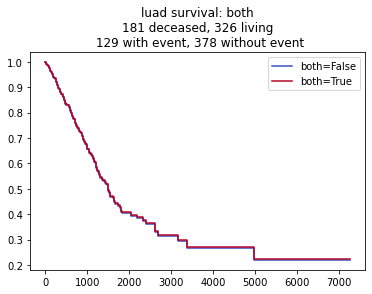

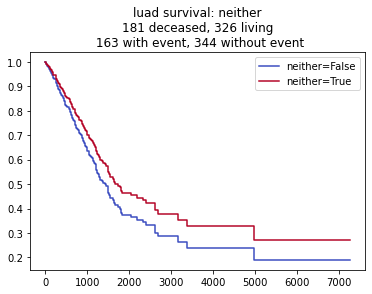

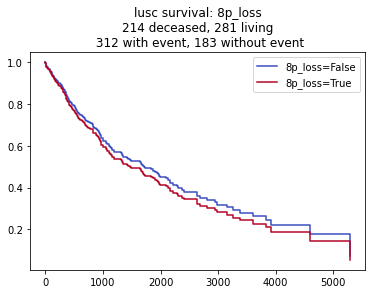

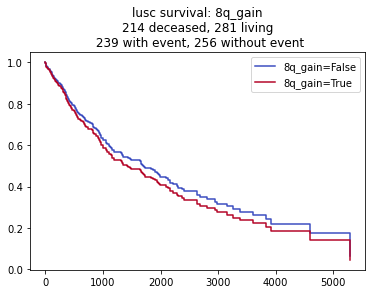

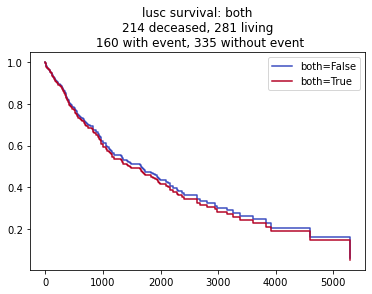

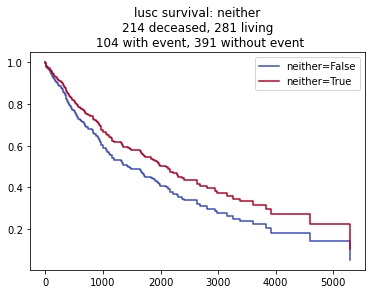

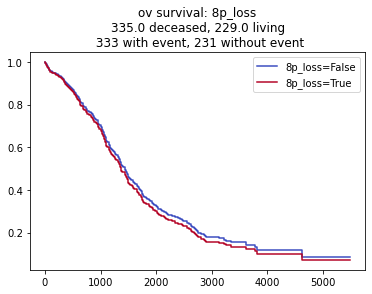

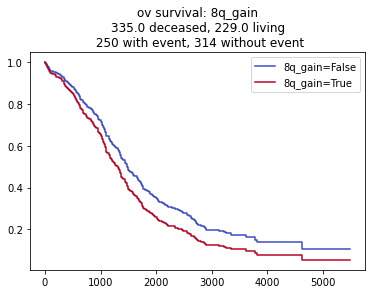

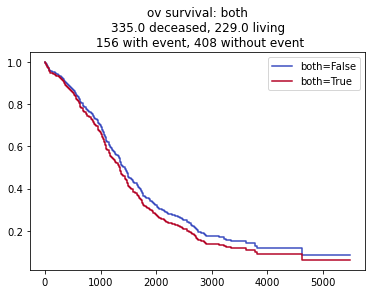

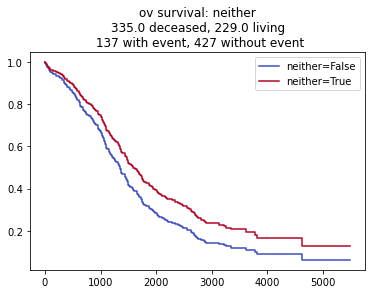

In [6]:
for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    for cnv_col in ["8p_loss", "8q_gain", "both", "neither"]:
        sel_df = df[["death", "days_to_last_contact_or_death", cnv_col]]
        plot_single_var_survival(cancer_type, sel_df, cnv_col)

## Plot multiple variables

In [7]:
def plot_multi_var_survival(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(cancer_type)
    cph.print_summary()
#     print(lifelines.statistics.proportional_hazard_test(cph, df))
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_8p_loss = df["8p_loss"].sum()
    no_8p_loss = df["8p_loss"].size - has_8p_loss
    
    has_8q_gain = df["8q_gain"].sum()
    no_8q_gain = df["8q_gain"].size - has_8q_gain
    
    plot_title = f"{cancer_type} survival: Chromosome 8\n{deceased_count} deceased, {living_count} living" +\
        f"\n{has_8p_loss} with 8p_loss, {no_8p_loss} without" +\
        f"\n{has_8q_gain} with 8q_gain, {no_8q_gain} without"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

brca


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -830.52
         time fit was run = 2020-11-06 01:21:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.48       1.62       0.18             0.13             0.83                 1.14                 2.30
8q_gain     0.07       1.07       0.17            -0.27             0.40                 0.77                 1.50

             z    p   -log2(p)
covariate                     
8p_loss   2.71 0.01       7.19
8q_gain   0.40 0.69       0.53
---
Concordance = 0.57
Partial AIC = 1665.04
log-likelihood ratio test = 9.04 on 2 df
-log2(p) of ll-ratio test = 6.52

coad


<lifelines.CoxPHFitter: fitted with 448 total observations, 347 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 448
number of events observed = 101
   partial log-likelihood = -535.90
         time fit was run = 2020-11-06 01:21:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.21       1.23       0.22            -0.22             0.63                 0.80                 1.88
8q_gain     0.03       1.03       0.22            -0.39             0.46                 0.68                 1.58

             z    p   -log2(p)
covariate                     
8p_loss   0.96 0.34       1.56
8q_gain   0.16 0.88       0.19
---
Concordance = 0.52
Partial AIC = 1075.80
log-likelihood ratio test = 1.24 on 2 df
-log2(p) of ll-ratio test = 0.89

hnsc


<lifelines.CoxPHFitter: fitted with 521 total observations, 302 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 521
number of events observed = 219
   partial log-likelihood = -1201.57
         time fit was run = 2020-11-06 01:21:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.31       1.37       0.14             0.03             0.59                 1.04                 1.81
8q_gain     0.02       1.02       0.14            -0.26             0.31                 0.77                 1.36

             z    p   -log2(p)
covariate                     
8p_loss   2.20 0.03       5.19
8q_gain   0.16 0.87       0.20
---
Concordance = 0.55
Partial AIC = 2407.14
log-likelihood ratio test = 5.59 on 2 df
-log2(p) of ll-ratio test = 4.03

luad


<lifelines.CoxPHFitter: fitted with 507 total observations, 326 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 507
number of events observed = 181
   partial log-likelihood = -966.31
         time fit was run = 2020-11-06 01:21:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.01       1.01       0.15            -0.29             0.31                 0.75                 1.37
8q_gain     0.16       1.17       0.15            -0.14             0.46                 0.87                 1.58

             z    p   -log2(p)
covariate                     
8p_loss   0.09 0.93       0.10
8q_gain   1.04 0.30       1.76
---
Concordance = 0.53
Partial AIC = 1936.62
log-likelihood ratio test = 1.18 on 2 df
-log2(p) of ll-ratio test = 0.85

lusc


<lifelines.CoxPHFitter: fitted with 495 total observations, 281 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 495
number of events observed = 214
   partial log-likelihood = -1136.95
         time fit was run = 2020-11-06 01:21:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.09       1.10       0.14            -0.19             0.38                 0.83                 1.46
8q_gain     0.11       1.11       0.14            -0.16             0.38                 0.85                 1.46

             z    p   -log2(p)
covariate                     
8p_loss   0.65 0.51       0.96
8q_gain   0.79 0.43       1.22
---
Concordance = 0.53
Partial AIC = 2277.91
log-likelihood ratio test = 1.14 on 2 df
-log2(p) of ll-ratio test = 0.83

ov


<lifelines.CoxPHFitter: fitted with 564 total observations, 229 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 564
number of events observed = 335
   partial log-likelihood = -1806.35
         time fit was run = 2020-11-06 01:21:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.04       1.04       0.11            -0.17             0.26                 0.84                 1.29
8q_gain     0.25       1.28       0.11             0.03             0.47                 1.03                 1.59

             z    p   -log2(p)
covariate                     
8p_loss   0.38 0.71       0.50
8q_gain   2.26 0.02       5.37
---
Concordance = 0.55
Partial AIC = 3616.70
log-likelihood ratio test = 5.50 on 2 df
-log2(p) of ll-ratio test = 3.97

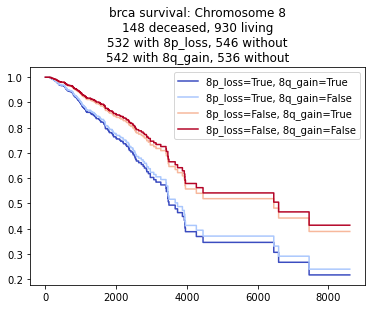

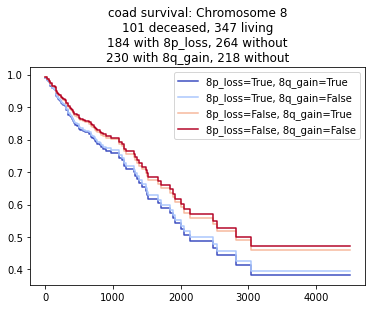

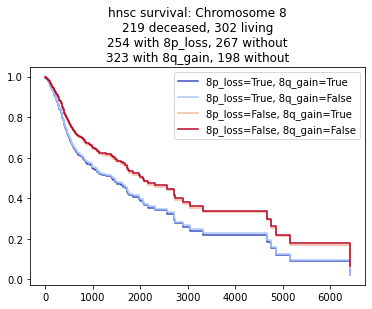

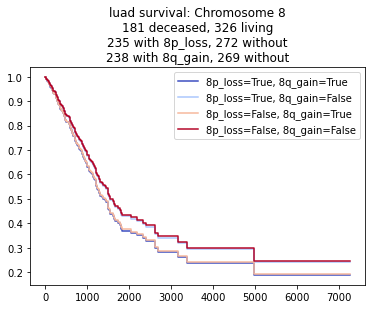

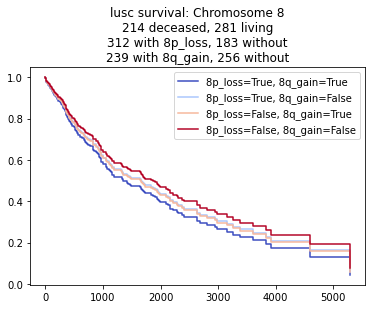

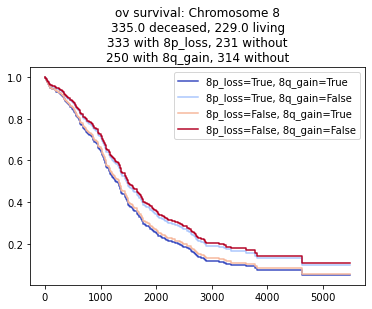

In [8]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    plot_multi_var_survival(cancer_type, df, cnv_cols)

## Plot confidence intervals

In [9]:
def plot_cis(cancer_type, df):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot(ax=plt.axes(label=cancer_type))

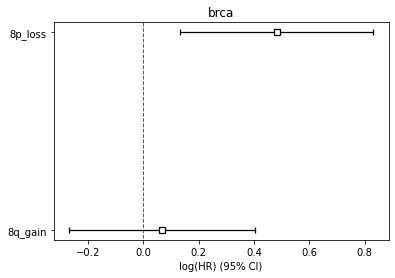

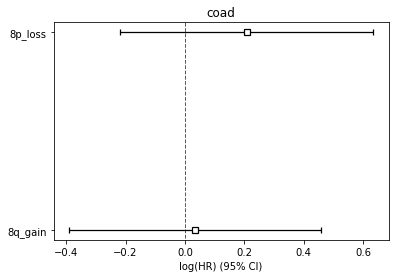

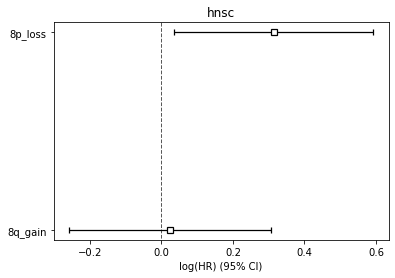

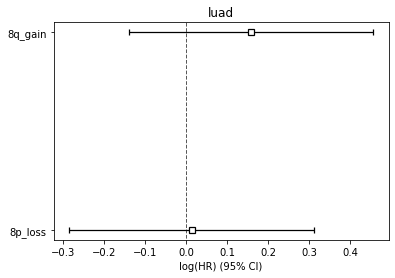

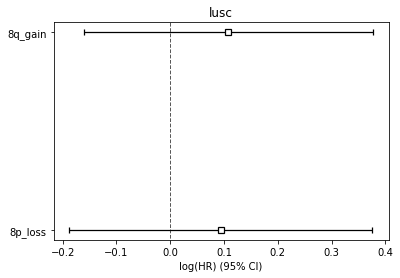

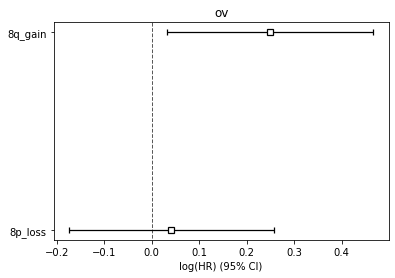

In [10]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    ax = plot_cis(cancer_type, df)
    ax.set_title(cancer_type)
    plt.show()